## SIFT: Scale invariant feature transform _(Lowe, 2014)_


This tutorial mainly follows:


1. The original paper (a recommended read): [{Distinctive Image Featuresfrom Scale-Invariant Keypoints (Lowe 2014)}](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)
2. Another tutorial at [{AI Shack | SIFT: Theory and Practice}](https://aishack.in/tutorials/sift-scale-invariant-feature-transform-introduction/) with adapting to new data and other considrations.

### Problem definition

* Features or **key-points** of an image are corners which are unique in the image.
* Harris is a corner detector, we have discussed Previously. 
* Corner detectors such as Harris operator are invariant for translation, illumination and rotation. **But it is variant for scaling**. 

### Example

Next figure shows two different scales of same image. 

<span style="display:block;text-align:center"><img style="width:75%"  src="media/sift_scale_invariant.jpg"></span>

* In smaller image,  it's easy to detect that there is a corner, but what about same image in the large scale. It will be difficult to detect that corner so this feature point will not be recognized for all scales. 
* So size of the window will effect the detection of corners. Large corners needs large windows and smaller corners needs smaller windows. 

Scale invariant feature descriptor (SIFT) is not a new way to find key-points or corners that is invariant to scale. But it is a descriptor of detected corners of different image scales or image pyramids.

### Key steps in SIFT

1. **Scale-space extrema detection**: _"The first stage of computation searches over all scalesand image locations.  It is implemented efficiently by using adifference-of-Gaussianfunction to identify potential interest points that are invariant to scale and orientation."_
1. **Keypoint localization**: _"At each candidate location, a detailed model is fit to determinelocation and scale. Keypoints are selected based on measures of their stability."_
1. **Orientation assignment:** _"One or more orientations are assigned to each keypoint lo-cation based on local image gradient directions.  All futureoperations are performedon image data that has been transformed relative to the assigned orientation, scale, andlocation for each feature, thereby providing invariance tothese transformations."_
1. **Keypoint descriptor:** _"The local image gradients  are measured at the selected scalein the region around each keypoint.  These are transformed into a representation thatallows for significant levels of local shape distortion and change in illumination."_

### A) Scale-space extrema detection

####  Image pyramids and scale-spaces

Image pyramids or image scale space is the proposed method to handle images in different scales. We have different scale-spaces 

* Gaussian scale space (Gaussian pyramid)
* Laplacian of gaussian (LOG) scale space 
* Difference of gaussian (DOG) scale space 

The basic idea to build scale space is shown in the following figure 

**Gaussian Pyramid**

<span style="display:block;text-align:center"><img style="width:55%"  src="media/Image_pyramid.png"></span>


[source](https://en.wikipedia.org/wiki/Pyramid_(image_processing))

**LOG Pyramid**

<span style="display:block;text-align:center"><img style="width:85%"  src="media/LOG.png"></span>


In SIFT we usually prefer DOG scale space which is an approximate of LOG and simpler in calculation. 


#### SIFT scale space (DOG)

In SIFT Pyramid we have 

* Octaves: different levels of image resolutions (pyramids levels)
* Scales: different scales of window in each octave level (different $\sigma$ of gaussian window)

![](media/sift_dog.jpg)

#### Practical details of constructing the scale space in SIFT

The following practices suggested by the SIFT author ([{Distinctive Image Featuresfrom Scale-Invariant Keypoints}](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) p. 7):


1. Overall, we consider four octaves (resolution levels, or image shapes). Each octave shape is $\times 2$ subsampling of its previous octave. So if first octave resolution is (64,64), the next resolutions are (32,32), (16,16), and (8,8).
1. For each octave, we consider five different blurred images ($\sigma, k \sigma, k^2 \sigma, k^3 \sigma, k^4 \sigma$); and $k=\sqrt{2}$. Hence, the squence of Gaussian blurring becomes ($\sigma,\sqrt{2} \sigma, 2 \sigma, 2\sqrt{2} \sigma, 4 \sigma$).
1. We start the first octave on a $\times 2$ upsampled from the input image. This allows extracting more features. So if the input image is (128,128), the four octaves will have the following resolutions: (256,256), (128,128), (64,64), and (32,32).
1. For the $2^{nd}-$, $3^{rd}-$, and $4^{th}-$octaves, we $\times 2$ subsample the image from the previous octave that has twice $\sigma$ of the initial image (which mean the third image). 
1. Finally, from each octave, we obtain 4 DoG images.
1. $\sigma = 1.6$ is chosen by the author for stable results (repeatability).

##### Let's declare the previous practical considerations before starting

In [9]:
from scipy.signal import convolve2d
from cvutils import gaussian_kernel2d
from skimage.transform import rescale
from math import sqrt
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Test
logger = logging.getLogger('SIFT')

# The following are suggested by SIFT author
N_OCTAVES = 4 
N_IMAGES_PER_OCTAVE = 5 
SIGMA = 1.6
K = sqrt(2)
SIGMA_SEQ = lambda s: [ (K**i)*s for i in range(N_IMAGES_PER_OCTAVE) ] # (s, √2s , 2s, 2√2 s , 4s )
SIGMA_SIFT = SIGMA_SEQ(SIGMA) #
KERNEL_RADIUS = lambda s : 2 * int(round(s))
KERNELS_SIFT = [ gaussian_kernel2d(std = s, kernlen = 2 * KERNEL_RADIUS(s) + 1) for s in SIGMA_SIFT ]

##### Now the routine of obtaining the DoG scale space

In [10]:
def image_dog( img ):
    octaves = []
    dog = []
    base = rescale( img, 2, anti_aliasing=False) 
    octaves.append([ convolve2d( base , kernel , 'same') for kernel in KERNELS_SIFT ])
    dog.append([ s2 - s1 for (s1,s2) in zip( octaves[0][:-1], octaves[0][1:])])
    for i in range(1,N_OCTAVES):
        base = octaves[i-1][2][::2,::2] # 2x subsampling 
        octaves.append([base] + [convolve2d( base , kernel , 'same') for kernel in KERNELS_SIFT[1:] ])
        dog.append([ s2 - s1 for (s1,s2) in zip( octaves[i][:-1], octaves[i][1:])])
        logger.info('Done {}/{} octaves'.format(i+1, N_OCTAVES))
    return dog , octaves

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import isfile , join
from PIL import Image
from cvutils import rgb2gray

imgs_dir = 'images'
imgs_names = ['IMG_1282.jpg']
imgs_fnames = [ join( imgs_dir, img_name) for img_name in imgs_names ]
imgs_rgb = [ np.array(Image.open(img)) for img in imgs_fnames ]
imgs_gray = [ rgb2gray( img ) for img in imgs_rgb ]
logger.info('shapes:{}'.format(''.join(map(lambda i: str(i.shape), imgs_rgb))))


INFO:SIFT:shapes:(3024, 4032, 3)


In [12]:
input_image = rescale( imgs_gray[0], 0.5 , anti_aliasing = True )
img_max = input_image.max()
img_dogs, img_octaves = image_dog( input_image )

INFO:SIFT:Done 2/4 octaves
INFO:SIFT:Done 3/4 octaves
INFO:SIFT:Done 4/4 octaves


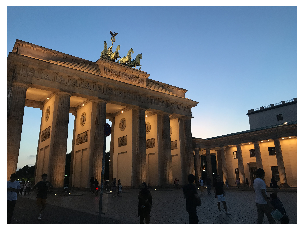

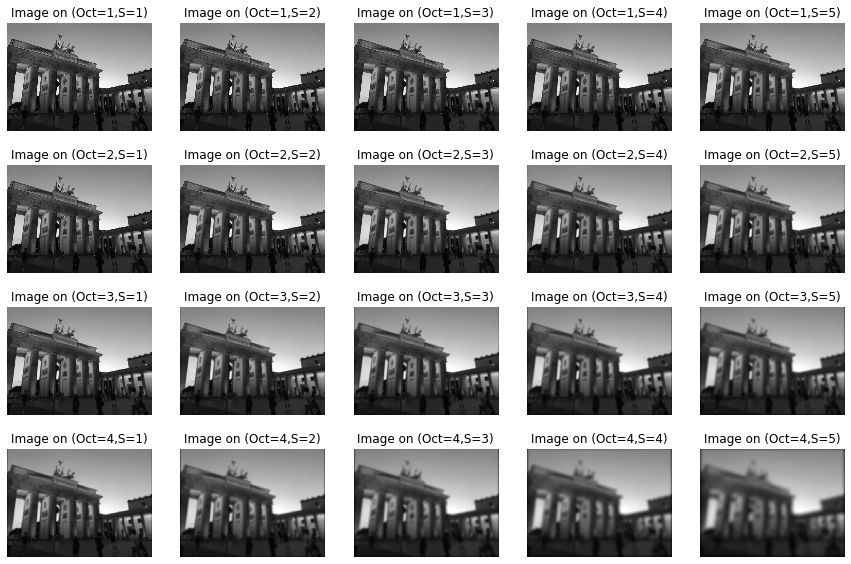

In [13]:
plt.imshow(imgs_rgb[0])
plt.axis('off')
plt.show()

fig, ax = plt.subplots(N_OCTAVES,N_IMAGES_PER_OCTAVE,figsize = (15, 10))
for octave_idx in range(N_OCTAVES):
    img_octave = img_octaves[octave_idx]
    for scale_idx in range(N_IMAGES_PER_OCTAVE):
        subplot = ax[octave_idx,scale_idx]
        subplot.axis('off')
        img_scale = img_octave[scale_idx]
        subplot.set_title('Image on (Oct={},S={})'.format(octave_idx+1,scale_idx+1))
        subplot.imshow(img_scale, cmap = 'gray')

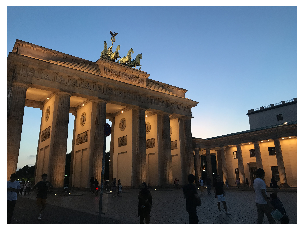

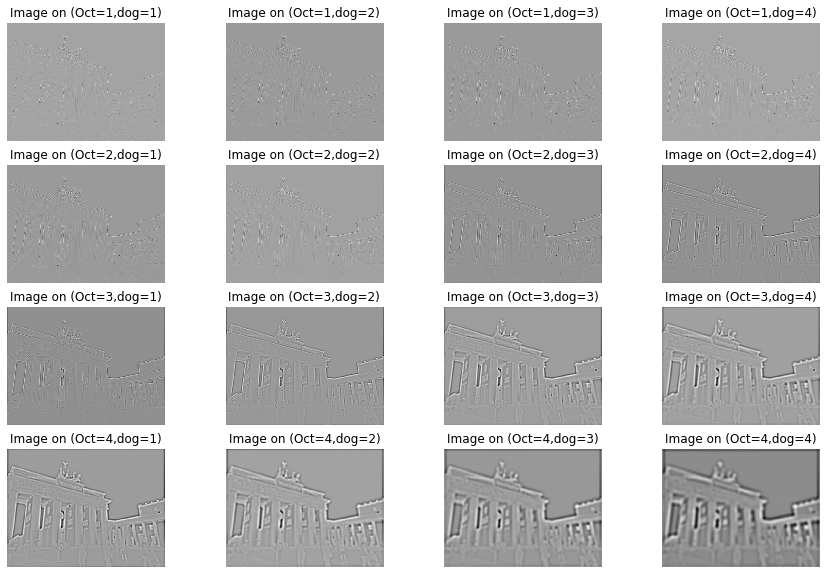

In [14]:
plt.imshow(imgs_rgb[0])
plt.axis('off')
plt.show()

fig, ax = plt.subplots(N_OCTAVES,N_IMAGES_PER_OCTAVE-1,figsize = (15, 10))
for octave_idx in range(N_OCTAVES):
    img_octave_dogs = img_dogs[octave_idx]
    for dog_idx in range(len(img_octave_dogs)):
        subplot = ax[octave_idx,dog_idx]
        subplot.axis('off')
        img_dog = img_octave_dogs[dog_idx]
        subplot.set_title('Image on (Oct={},dog={})'.format(octave_idx+1,dog_idx+1))
        subplot.imshow(img_dog, cmap = 'gray')

#### Key-point (corner) scale localization

For each key-point (corner) we need to find its best scale which have maximum value (cornerness measure). It is achieved by comparing same corner with its neighbors of above and lower scales and select scale with maximum value. For same iamge, it is not necessary for its corners to be localized at same scale.

![](media/sift_local_extrema.jpg)

##### Eliminating Edge Response

We need to reject all points that corresponds to edges in a way similar to Harris operator.
We will use the following Hessian matrix to get the two principal curvatures of $D$ which correspond to the two eigen values of $\mathbf{H}$
$$ \mathbf{H} = 
\begin{bmatrix}
D_{xx}       & D_{xy} \\\
D_{xy}      & D_{yy}
\end{bmatrix}
$$
Derivatives are simply caluclated as the difference between the neighboring pixels.

To quantify cornerness we will assume the two eigen values are $\lambda_1$ and $\lambda_2$, and the ration between them is $r$ so $\lambda_1 = r \lambda_2$. 

Note that:

$$\text{Tr}(\mathbf{H}) = D_{xx} + D_{yy} = \lambda_1 + \lambda_2$$
$$\text{Det}(\mathbf{H}) = D_{xx} D_{yy} - D_{xy}^2 = \lambda_1 \lambda_2$$

Consider the following quantity:

$$ \frac{\text{Tr}(\mathbf{H})^2}{\text{Det}(\mathbf{H})} = \frac{(\lambda_1 + \lambda_2)^2}{\lambda_1\lambda_2}\$$

$$ = \frac{(r\lambda_2 + \lambda_2)^2}{r\lambda_2^2} $$

$$ = \frac{(r+1)^2}{r^2} $$

So we may select a threshold ratio $r$ between the two principal components and accordingly based on the quantity $\frac{\text{Tr}(\mathbf{H})^2}{\text{Det}(\mathbf{H})} < \frac{(r+1)^2}{r^2} $

###### Implementation

In [15]:
def corners( dog , r = 10.0 ):
    threshold = ((r + 1.0)/r)**2 
    h, w = dog.shape
    column = np.zeros((h,1), dog.dtype)
    row = np.zeros((1,w), dog.dtype )
    
    dx = dog[:,1:] - dog[:,:-1]
    dx = np.hstack((column,dx))
    
    dy = dog[:-1,:] - dog[1:,:]
    dy = np.vstack((row,dy))
    
    dxx = dx[:,1:] - dx[:,:-1]
    dxx = np.hstack((column,dxx))
    
    dyy = dy[:-1,:] - dy[1:,:]
    dyy = np.vstack((row,dyy))
    
    dxy = dx[:-1,:] - dx[1:,:]
    dxy = np.vstack((row,dxy))
    
    assert all( im.shape == dog.shape for im in (dx,dy,dxx,dyy,dxy)), "Shape mismatch!"
    
    tr = dxx + dyy
    det = dxx * dyy - dxy ** 2
    response = np.zeros_like( dog )
    nonzero = det > np.finfo(np.float32).eps
    
    response[nonzero] = ( tr[nonzero] ** 2 ) / det[nonzero]
    
    coords = list(map( tuple , np.argwhere( response > threshold ).tolist() ))
    return coords
    
    

##### Eliminating Low Contrast

In [16]:
def contrast( dog , img_max, threshold = 0.03 ):
    dog_norm = dog / img_max
    coords = list(map( tuple , np.argwhere( np.abs( dog_norm ) > threshold ).tolist() ))
    return coords

In [51]:


def cube_extrema( img1, img2, img3 ):
    value = img2[1,1]

    if value > 0:
        return all([np.all( value >= img ) for img in [img1,img2,img3]]) # test map
    else:
        return all([np.all( value <= img ) for img in [img1,img2,img3]]) # test map


def dog_keypoints( img_dogs , img_max , threshold = 0.03 ):
    octaves_keypoints = []
    
    for octave_idx in range(N_OCTAVES):
        img_octave_dogs = img_dogs[octave_idx]
        keypoints_per_octave = []
        for dog_idx in range(1, len(img_octave_dogs)-1):
            dog = img_octave_dogs[dog_idx]
            keypoints = np.full( dog.shape, False, dtype = np.bool)
            candidates = set( (i,j) for i in range(1, dog.shape[0] - 1) for j in range(1, dog.shape[1] - 1))
            search_size = len(candidates)
            candidates = candidates & set(corners(dog)) & set(contrast( dog , img_max, threshold ))
            search_size_filtered = len(candidates)
            logger.info('Search size reduced by: {:.1f}%'.format( 100*(1 - search_size_filtered/search_size )))
            for i,j in candidates:
                slice1 = img_octave_dogs[dog_idx -1][i-1:i+2, j-1:j+2]
                slice2 = img_octave_dogs[dog_idx   ][i-1:i+2, j-1:j+2]
                slice3 = img_octave_dogs[dog_idx +1][i-1:i+2, j-1:j+2]
                if cube_extrema( slice1, slice2, slice3 ):
                    keypoints[i,j] = True
            keypoints_per_octave.append(keypoints)
        octaves_keypoints.append(keypoints_per_octave)
    return octaves_keypoints

%reload_ext autoreload
%autoreload 2
import cvutils
import importlib
importlib.reload(cvutils)
from cvutils import padded_slice
def dog_keypoints_orientations( img_gaussians , keypoints , num_bins = 36 ):
    octaves_kps = []
    for octave_idx in range(N_OCTAVES):
        img_octave_gaussians = img_gaussians[octave_idx]
        octave_keypoints = keypoints[octave_idx]
        kps_per_octave = []
        for idx,scale_keypoints in enumerate(octave_keypoints):
            scale_idx = idx + 1 ## idx+1 to be replaced by quadratic localization
            gaussian_img = img_octave_gaussians[ scale_idx ] 
            sigma = 1.5 * SIGMA * ( 2 ** octave_idx ) * ( K ** (scale_idx))
            radius = KERNEL_RADIUS(sigma)
            kernel = gaussian_kernel2d(std = sigma, kernlen = 2 * radius + 1)
            
            h, w = gaussian_img.shape
            pad_col = np.zeros((h,1), gaussian_img.dtype)
            pad_row = np.zeros((1,w), gaussian_img.dtype )
            
            dx = gaussian_img[:,2:] - gaussian_img[:,:-2]
            dx = np.hstack((pad_col,dx,pad_col))

            dy = gaussian_img[:-2,:] - gaussian_img[2:,:]
            dy = np.vstack((pad_row,dy,pad_row))

            magnitude = np.sqrt( dx * dx + dy * dy )
            direction = np.rad2deg( np.arctan2( dy , dx ))
            direction_idx = np.round(direction / num_bins ).astype(int)
            direction_idx = direction_idx % num_bins
            
            for i,j in map( tuple , np.argwhere( scale_keypoints ).tolist() ):
                window = [i-radius, i+radius+1, j-radius, j+radius+1]
                mag_win = padded_slice( magnitude , window )
                dir_idx = padded_slice( direction_idx, window )
                weight = mag_win * kernel 
                hist = np.zeros(num_bins, dtype=np.float32)
                for bin_idx in range(num_bins):
                    hist[bin_idx] = np.sum( weight[ dir_idx == bin_idx ] )
            
             
                for bin_idx in np.argwhere( hist >= 0.8 * hist.max() ).tolist():
                    kps_per_octave.append( (i,j,scale_idx,(bin_idx[0]+0.5) * (360./num_bins)))
        octaves_kps.append( kps_per_octave )
    return octaves_kps
                
                

In [52]:
# print(img_max)
keypoints = dog_keypoints( img_dogs , img_max , 0.03 )

254.5707337924028
INFO:SIFT:Search size reduced by: 99.4%
INFO:SIFT:Search size reduced by: 98.9%
INFO:SIFT:Search size reduced by: 99.2%
INFO:SIFT:Search size reduced by: 98.5%
INFO:SIFT:Search size reduced by: 98.8%
INFO:SIFT:Search size reduced by: 97.5%
INFO:SIFT:Search size reduced by: 97.8%
INFO:SIFT:Search size reduced by: 95.1%


In [53]:
# print(len(keypoints))

4


In [54]:
# Each keypoint has four parameters (i,j,scale_idx,orientation)
keypoints_ijso = dog_keypoints_orientations( img_octaves , keypoints , 36 )

In [50]:
# keypoints_ijso

[[(337, 1434, 1, 15.0),
  (337, 1434, 1, 25.0),
  (337, 1434, 1, 55.0),
  (337, 1440, 1, 15.0),
  (340, 1429, 1, 55.0),
  (350, 1429, 1, 55.0),
  (359, 1430, 1, 315.0),
  (362, 1488, 1, 45.0),
  (368, 1537, 1, 35.0),
  (368, 1544, 1, 35.0),
  (369, 1432, 1, 315.0),
  (369, 1432, 1, 325.0),
  (372, 1438, 1, 315.0),
  (372, 1484, 1, 315.0),
  (374, 1546, 1, 355.0),
  (375, 1530, 1, 35.0),
  (377, 1434, 1, 325.0),
  (378, 1518, 1, 35.0),
  (382, 1535, 1, 355.0),
  (382, 1541, 1, 355.0),
  (391, 1442, 1, 325.0),
  (401, 1499, 1, 45.0),
  (401, 1499, 1, 55.0),
  (408, 1449, 1, 315.0),
  (408, 1449, 1, 325.0),
  (410, 1493, 1, 45.0),
  (413, 1477, 1, 5.0),
  (413, 1477, 1, 35.0),
  (413, 1477, 1, 355.0),
  (415, 1489, 1, 5.0),
  (415, 1489, 1, 35.0),
  (417, 1494, 1, 5.0),
  (420, 1469, 1, 335.0),
  (427, 1474, 1, 55.0),
  (427, 1497, 1, 5.0),
  (427, 1497, 1, 15.0),
  (427, 1497, 1, 345.0),
  (428, 1456, 1, 35.0),
  (431, 1466, 1, 35.0),
  (431, 1466, 1, 335.0),
  (433, 1458, 1, 35.0),
  (4

##### Side question

Why using Python `map` function in `cube_extrema` would be more efficient?

In [40]:
import time

x1 = np.random.randint(2, size=1000000)
x2 = np.random.randint(2, size=1000000)
x3 = np.random.randint(2, size=1000000)

t = time.process_time()
print('(x1,x2,x3) has 1? a:{}'.format( "True" if any( [ any( x == 1 ) for x in (x1,x2,x3)])  else "False"))
time_any1 = time.process_time() - t 
logger.info('time of any(list/array):{}'.format( time_any1 ))

t = time.process_time()
print('(x1,x2,x3) has 1? a:{}'.format( "True" if any( map( lambda x: any(map( lambda xi: xi == 1 , x)), (x1,x2,x3)))  else "False"))
time_any2 = time.process_time() - t 
logger.info('time of any(map):{}'.format( time_any2 ))

logger.info('time of any1/any2 = {}'.format( time_any1 / time_any2))

(x1,x2,x3) has 1? a:True
INFO:SIFT:time of any(list/array):0.0031156540001120447
(x1,x2,x3) has 1? a:True
INFO:SIFT:time of any(map):0.0001908199999434146
INFO:SIFT:time of any1/any2 = 16.32771198530529


### Extract SIFT feature descriptor

![](media/sift-fingerprint.jpg)

[source](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-features/)

After localization of a key-point in our scale space. We can get its SIFT descriptor as follow

* Extract a $16 \times 16$ window centered by this point.
* Get gradient magnitude and multiply it by a $16 \times 16$ gaussian window of $\sigma =1.5$
* Get gradient angle direction. 
* Adjusting orientation (To be rotation invariant):
    * Get the gradient angle of the window and Quantize them to 36 values (0, 10, 20, ..., 360)
    * Locate dominant corner direction which is most probable angle (angle with max value in 36 bit angle histogram)
    * subtract dominant direction from gradient angle.

![](media/siftOriented.png)

* Divide this $16 \times 16$ patch to sixteen $4 \times 4$ blocks
* For each block get magnitude weighted angle histogram and normalize it (divide by total gradient magnitudes). 
* angles (quantized to 8 angles [0, 45, 90, ... , 360]) based on its relevant gradient magnitude i.e (histogram of angle 0 = sum(all magnitudes with angle 0))

 ![](media/histangles.png)

* SIFT feature descriptor will be a vector of 128 element (16 blocks $\times$ 8 values from each block)
* Finally, to mitigate the non-linear illumination effects within an image and across large databases, we normalize the $1 \times 128$ vector to a unit vector. After that, we clip feature values larger than 0.2 then renormalize again.
> Finally, the feature vector is modified to reduce the effectsof illumination change.  First,the vector is normalized to unit length. A change in image contrast in which each pixel valueis  multiplied  by  a  constant  will  multiply  gradients  by  the  same  constant,  so  this  contrastchange will be canceled by vector normalization.  A brightness change in which a constantis added to each image pixel will not affect the gradient values, as they are computed frompixel  differences.   Therefore,  the  descriptor  is  invariantto  affine  changes  in  illumination.However, non-linear illumination changes can also occur due to camera saturation or due toillumination changes that affect 3D surfaces with differing orientations by different amounts.These effects can cause a large change in relative magnitudes for some gradients, but are lesslikely to affect the gradient orientations. Therefore, we reduce the influence of large gradientmagnitudes  by thresholding  the values in the unit feature vector to each be no larger than0.2,  and then  renormalizing  to unit length.   This means  that matching  the magnitudes  forlarge gradients is no longer as important, and that the distribution of orientations has greateremphasis. The value of 0.2 was determined experimentally using images containing differingilluminations for the same 3D objects. (Lowe, 2014, p. 16).   

In [62]:
def interpixels_image( img ):
    inter = np.zeros( (img.shape[0]+1, img.shape[1]+1) )
    inter[:-1,:-1] += img
    inter[1:,1:] += img
    inter[:-1,1:] += img
    inter[1:,:-1] += img
    return inter/4.

In [68]:
def extract_sift_descriptors128( img_gaussians, keypoints, num_bins = 8 ):
    descriptors = []
    for octave_idx in range(N_OCTAVES):
        img_octave_gaussians = img_gaussians[octave_idx]
        octave_keypoints = keypoints[octave_idx]
        descriptors.append([])
        
        scale_data = {} # 
        window_data = {}
        
        for (i,j,scale_idx, orientation) in octave_keypoints:
            
            if 'index' not in scale_data or scale_data['index'] != scale_idx:
                scale_data['index'] = scale_idx
                gaussian_img = img_octave_gaussians[ scale_idx ] 
                sigma = 1.5 * SIGMA * ( 2 ** octave_idx ) * ( K ** (scale_idx))
                scale_data['kernel'] = gaussian_kernel2d(std = sigma, kernlen = 16)
                
                h, w = gaussian_img.shape
                pad_col = np.zeros((h,1), gaussian_img.dtype)
                pad_row = np.zeros((1,w), gaussian_img.dtype )

                dx = gaussian_img[:,2:] - gaussian_img[:,:-2]
                dx = np.hstack((pad_col,dx,pad_col))

                dy = gaussian_img[:-2,:] - gaussian_img[2:,:]
                dy = np.vstack((pad_row,dy,pad_row))

                scale_data['inter_magnitude'] = interpixels_image(np.sqrt( dx * dx + dy * dy ))
                scale_data['inter_direction'] = interpixels_image(np.rad2deg( np.arctan2( dy , dx )))
                
            if 'index' not in window_data or window_data['index'] != (i,j):
                window_data['index'] = (i,j)
                region = [i-8+1, i+8+1, j-8+1, j+8+1]
                window_mag = padded_slice( scale_data['inter_magnitude'], region )
                window_data['dir'] = padded_slice( scale_data['inter_direction'], region )
                window_data['weights'] = window_mag = scale_data['kernel']
                
            window_dir_norm = (window_data['dir'] - orientation)
            direction_idx = np.round(window_dir_norm / num_bins ).astype(int)
            direction_idx = direction_idx % num_bins
            
            features = []
            for sub_i in range(4):
                for sub_j in range(4):
                    sub_weights = window_data['weights'][sub_i*4:(sub_i+1)*4, sub_j*4:(sub_j+1)*4]
                    sub_dir_idx = direction_idx[sub_i*4:(sub_i+1)*4, sub_j*4:(sub_j+1)*4]
                    hist = np.zeros(num_bins, dtype=np.float32)
                    for bin_idx in range(num_bins):
                        hist[bin_idx] = np.sum( sub_weights[ sub_dir_idx == bin_idx ] )
                    features.extend( hist.tolist())
            features = np.array(features) 
            features /= (np.linalg.norm(features))
            np.clip( features , np.finfo(np.float16).eps , 0.2 , out = features )
            assert features.shape[0] == 128, "features missing!"
            features /= (np.linalg.norm(features))
            descriptors[-1].append((i,j,scale_idx,features))
    return descriptors

            

In [69]:
descriptors = extract_sift_descriptors128(img_octaves , keypoints_ijso , 8)

In [72]:
# descriptors
print( sum( map(len, keypoints_ijso)))
print( sum( map(len, descriptors)))

8868
8868


## Feature matching

The basic idea of feature matching is to calculate the sum square difference between two different feature descriptors (SSD). So feature will be matched with another with minimum SSD value. 

$$
SSD = \sum (v_1 - v_2)^2
$$

where $$v_1$$ and $$v_2$$ are two feature descriptors.

![](media/matcher_result1.jpg)


### Brute-Force matcher

In brute-force matcher we have to match descriptor of all features in an image to descriptors of all features in another image. It is extremely expensive as we know any brute-force algorithm will guarantee getting a solution, but doesn't guarantee getting optimal solution.

### RANSAC 

Random sample consensus is an iterative method for estimation of parameters of a mathematical model. We will model the transformation of points in source image to destination one, and try to find an estimate of model parameters. The basic idea of RANSAC algorithm is shown in the following flow chart. 

<!-- ![](media/ransac.png) -->

RANSAC is a robust feature matcher. For example we can model the difference between two images to a set of transformations and run RANSAC to find best model that maximize correct matching.